<a href="https://colab.research.google.com/github/zeyn-zeze/Basic-Car-Invantory-Stock-System-/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN(Recurrent Neural Network)


1.   RNN Giriş
2.   İleriye Yayılım
3.   Zamanla Geriye Yayılım (BPTT)
4.   Uzun Kısa Süreli Bellek (LSTM)





# 1.RNN GİRİŞ
RNN (Recurrent Neural Network), dizi şeklindeki verilerle çalışmak üzere tasarlanmış özel bir yapay sinir ağı türüdür. Bu ağlar, sıradan sinir ağlarından farklı olarak zaman veya sıra bağımlılıklarını öğrenebilirler. RNN’ler, önceki girdilerle ilgili bilgileri hafızada tutarak, zaman içinde sıralı verilerdeki ilişkileri yakalayabilirler. Bu, özellikle doğal dil işleme, konuşma tanıma, zaman serisi analizi gibi uygulamalarda önemlidir.

RNN’in yapısını daha farklı bir şekilde açıklayabiliriz:

Zaman Bağlantıları: RNN, zaman adımlarındaki girdileri işleyerek, her adımda önceki durumu dikkate alır. Bu nedenle, diziler arası bağları anlamak ve işlemek için idealdir.

Döngüsel Yapı: RNN'in katmanlarında geri besleme döngüsü bulunur. Yani, her zaman adımında ağın çıktısı, bir sonraki adımda giriş olarak kullanılır. Bu döngü, geçmiş bilgiyi hatırlamayı sağlar.

Hafıza Kapasitesi: RNN’ler özellikle kısa süreli hafızada etkilidir, ancak uzun süreli bağımlılıkları öğrenmekte sorun yaşarlar. Bu sorunu çözmek için LSTM (Long Short-Term Memory) ve GRU (Gated Recurrent Unit) gibi RNN türleri geliştirilmiştir.

Özetle, RNN, dizilerdeki ardışık ilişkileri öğrenebilen ve zaman bağımlılıklarından faydalanarak gelecekteki adımları tahmin edebilen bir yapay sinir ağıdır.

# 1)İş Problemi


*   **Month:**aylık olarak yer alan tarih değişkenidir.
*   **Passengers**:İlgili işlem tarihindeki yolcu sayısını,yeni aylık yolcu sayısını temsil etmektedir.



# 2)Veriyi Anlama

2.1)Gerekli kütüphanelerin yüklenmesi

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

#model değerlendirme ve veriyi scale etme için
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Dropout,SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

#tf warningleri engelleme
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)


2.2)Verisetini yüklenmesi ve verinin genel resminin incelenmesi

In [ ]:
df = pd.read_csv("/international-airline-passengers.csv")

In [ ]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [ ]:
df.columns = ['Month','Passengers']
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [ ]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [ ]:
df.shape

(145, 2)

In [ ]:
df.dtypes

,0
Month,object
Passengers,float64


In [ ]:
df.isnull().sum() # son değerdeki eksik değer

,0
Month,0
Passengers,1


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


Toplam: 144 ay (son ay eksik olduğu için sayılmamış)

Ortalama 280 yolcu yolculuk yapmıştır.
min 104 max 622 kişiyle yolculuk yapılmıştır.

Medyan değeri : 265

Standrat sapma : 119 -  Ortalama: 280

Aralarındaki farkın bu kadar fazla olması değişkenlik ve yayılım fazladır.

Ortalama ile medyan arasında fazla fark yok.





# 3)Veriyi Hazırlama(Data Processing)

In [ ]:
df = df[:144]
df.tail()
#sonuncu eksik veri çıkarıldı

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
df["Month"] = pd.to_datetime(df["Month"])
df.info()
#datatype'ı object'ten datetime'a çevrilmiştir.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [ ]:
print("Maksimum Tarih : ",df['Month'].max())
print("Minimum Tarih : ",df['Month'].min())

Maksimum Tarih :  1960-12-01 00:00:00
Minimum Tarih :  1949-01-01 00:00:00


In [ ]:
df.index =df["Month"]
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [ ]:
df.drop("Month",axis=1,inplace=True)

In [ ]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [ ]:
result_df = df.copy()

<Axes: title={'center': 'Monthly International Airline Passengers'}, xlabel='Month'>

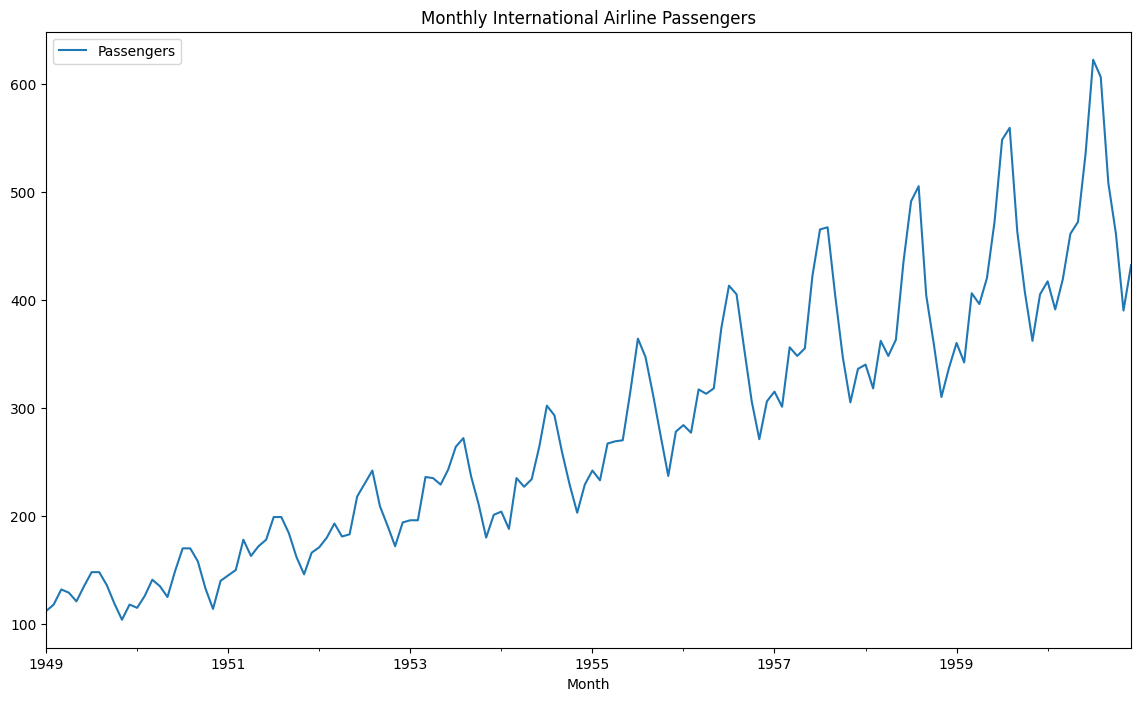

In [ ]:
df.plot(figsize=(14,8),title='Monthly International Airline Passengers')

In [ ]:
data =df["Passengers"].values
data[0:5]

array([112., 118., 132., 129., 121.])

In [ ]:
type(data)

numpy.ndarray

In [ ]:
type(data[0])

numpy.float64

In [ ]:
data=data.astype('float32')

In [ ]:
data.shape

(144,)

In [ ]:
data =data.reshape(-1,1)
data.shape
#tek boyutlu 144 gözlemden oluşan bir diziye çevrildi.

(144, 1)

İşlemler zaman serisi verisi üzerinde gerçekleştiği için modeli eğitme ve test-train formatında döndürme işlemleri sklearn içindeki methodlarla çok yararlı bir analiz yapmamaktadır bu sebeple default fonksiyon üzerinden zaman serisi verisi incelenmektedir.

Aşağıdaki methodda zaman serisi verisini ayırma işlemi için bir dataframe verilmesi gerekir, testsize miktarı da hangi oranda test olarak eğitilmesi istenirse o miktar alınır.

test = 0.33 train = 0.67

dataframeden nereye kadar gideleceği bilgisi de position da alınmaktadır.

In [ ]:
def split_data(dataframe,test_size):
  position = int(round(len(dataframe)*(1-test_size)))
  train_data = dataframe[:position]
  test_data = dataframe[position:]
  return train_data,test_data,position

In [ ]:
train,test,position = split_data(data,0.33)


In [ ]:
print(train.shape,test.shape)

(96, 1) (48, 1)


In [ ]:
scaler_train = MinMaxScaler(feature_range=(0,1))


In [ ]:
train = scaler_train.fit_transform(train)

In [ ]:
scaler_test = MinMaxScaler(feature_range=(0,1))
test = scaler_test.fit_transform(test)

train ve test setlerinin ayrı şekilde scaler edilmesi gerekmektedir.

Eğer aynı şekilde işlem görürse Data Leakage denilen veri sızıntısı problemi ile karşılaşılabilinir.



In [ ]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [ ]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [ ]:
def create_features(data,lookback):
  X,Y=[],[]
  for i in range(lookback,len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])
  return np.array(X),np.array(Y)

In [ ]:
lookback=1

In [ ]:
#Train veri seti
X_train,y_train = create_features(train,lookback)

In [ ]:
#Test Veri Seti
X_test,y_test= create_features(test,lookback)

In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(95, 1) (95,)
(47, 1) (47,)


In [ ]:
X_train = np.reshape(X_train,(X_train.shape[0],1,X_train.shape[1]))
X_test = np.reshape(X_test,(X_test.shape[0],1,X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

# 4-)Modelleme

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1],lookback)))
model.add(Dropout(0.2))
model.add(Dense(1))


In [ ]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Optimizasyon Ve Değerlendirme Metrikleri Ayarlanması

model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',patience=3,verbose=1,mode='min'),
             ModelCheckpoint(filepath='best_model.keras',monitor='val_loss',save_best_only=True,save_weights_only=False,verbose=1,mode='min')]

In [ ]:
history=model.fit(x = X_train,
                  y= y_train,
                  epochs = 50,
                  batch_size=1,
                  validation_data=(X_test,y_test),
                  callbacks=callbacks,
                  shuffle=False)

Epoch 1/50
78/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0142
Epoch 1: val_loss improved from inf to 0.03724, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0163 - val_loss: 0.0372
Epoch 2/50
84/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0411
Epoch 2: val_loss improved from 0.03724 to 0.02876, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0393 - val_loss: 0.0288
Epoch 3/50
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0259
Epoch 3: val_loss improved from 0.02876 to 0.02442, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0254 - val_loss: 0.0244
Epoch 4/50
86/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166
Epoch 4: val_loss improved from 0.02442 to 0.02312, saving model to best_model.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0231
Epoch 5/50
87/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0149
Epoch 5: val_loss improved from 0.02312 to 0.02

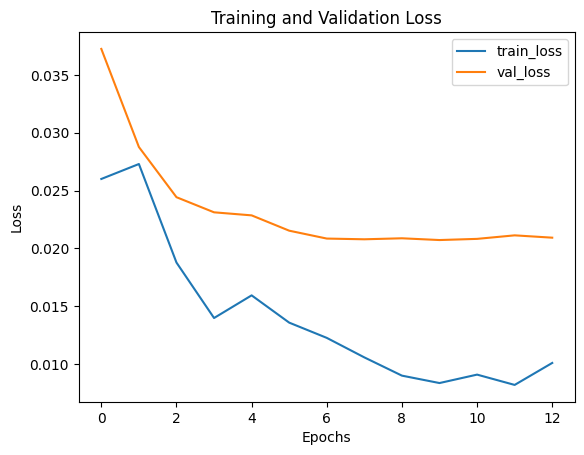

In [ ]:
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# 5) Değerlendirme

In [ ]:
loss = model.evaluate(X_test,y_test,batch_size=1)
print("Test loss:%.1f%%" % (100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0165
Test loss:2.1%


In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [ ]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [ ]:
#train veri setine ait RMSE değeri
train_rmse = np.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
#test veri setine ait RMSE dğeri
test_rmse = np.sqrt(mean_squared_error(y_test,test_predict))

In [ ]:
print(f"Train RMSE:{train_rmse}")
print(f"Test RMSE:{test_rmse}")

Train RMSE:23.956871032714844
Test RMSE:46.43320083618164


In [ ]:
train_prediction_df=result_df[lookback:position]

In [ ]:
train_prediction_df['Prediction'] = train_predict

In [ ]:
train_prediction_df.head()

,Passengers,Prediction
Month,,
1949-02-01,118.0,134.188232
1949-03-01,132.0,138.370895
1949-04-01,129.0,148.849213
1949-05-01,121.0,146.519272
1949-06-01,135.0,140.462234


In [ ]:
test_prediction_df=result_df[position+lookback:] # Change made here
test_prediction_df["Prediction"]=test_predict
test_prediction_df.head()

,Passengers,Prediction
Month,,
1957-02-01,301.0,336.326691
1957-03-01,356.0,327.266510
1957-04-01,348.0,369.783875
1957-05-01,355.0,362.645630
1957-06-01,422.0,368.891632


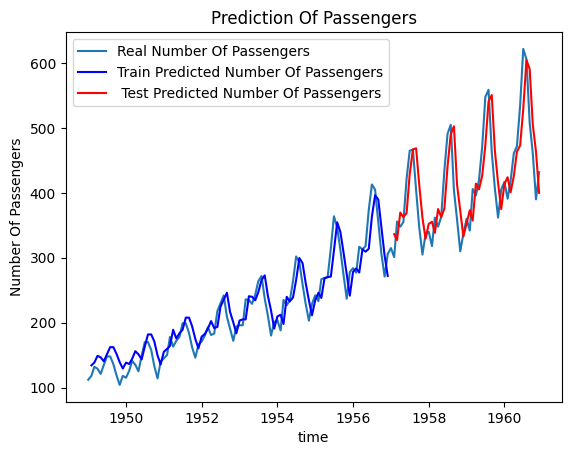

In [ ]:

plt.plot(result_df,label='Real Number Of Passengers')
plt.plot(train_prediction_df['Prediction'],color='blue',label='Train Predicted Number Of Passengers')
plt.plot(test_prediction_df['Prediction'],color='red',label=' Test Predicted Number Of Passengers')
plt.xlabel('time')
plt.ylabel('Number Of Passengers')
plt.title('Prediction Of Passengers')
plt.legend()
